# Global-Macro Testing:

In [17]:
import numpy as np
import pandas as pd
import yfinance as yf
import fredapi as fa
import seaborn as sns

#ML
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import ElasticNet
from sklearn.linear_model import Lasso
import hvplot.pandas
import xgboost as xgb


from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn import tree
from sklearn.tree import export_graphviz

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.mstats import winsorize
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor

In [9]:
dataframe = pd.read_csv('global_macro_etf_Data.csv', index_col = 0)

In [10]:
returns = dataframe.pct_change()
returns_cleaned = returns.dropna()
returns_cleaned.head()

,MSCI Asia Ex Japan,SP & ASX 200,ASX Small Ords,MSCI Brazil,MSCI China,MSCI Europe,MSCI ACWI,MSCI Global Small,MSCI India,MSCI Japan,...,Australian Bank Bill 90 Days,JP Morgan EMBI Global Diversified Composite,Barclays Global Aggregate,Barclays Global Aggregate Credit,Barclays Global High Yield Total return,Barclays US Treasury,Bloomberg Commodity Index,WTI Crude Spot,Gold,Rogers Int Agriculture Commodity Index
Date,,,,,,,,,,,,,,,,,,,,,
31/12/2001,-0.001576,0.027697,0.018739,0.161748,0.024220,0.038925,0.027322,0.047300,0.021631,-0.050842,...,0.003623,0.030848,-0.020899,-0.015653,-0.001470,-0.009738,-0.000841,0.041767,0.016582,-0.004686
31/01/2002,-0.031077,0.012968,0.036505,-0.062729,-0.087980,-0.039204,-0.023868,-0.014061,0.024504,-0.072514,...,0.003565,0.023648,-0.008984,-0.004592,0.008282,0.006734,-0.001683,-0.011757,0.012906,0.009364
28/02/2002,0.008554,-0.010876,-0.006062,0.121543,-0.010327,-0.016342,-0.026530,-0.026491,0.043365,0.026085,...,0.003293,0.012475,0.006721,0.005344,0.002290,0.009007,0.005893,0.095710,0.049549,-0.020736
29/03/2002,0.024396,0.003421,0.016078,-0.032146,0.022818,0.020061,0.011163,0.043945,-0.041765,0.023684,...,0.003483,-0.030700,-0.005909,-0.009351,0.018196,-0.024058,0.065048,0.170997,0.020570,-0.005237
30/04/2002,0.027318,-0.017935,-0.031058,-0.023649,0.034350,-0.012051,-0.042188,0.007100,-0.048523,0.048530,...,0.003777,0.004078,0.029595,0.023876,0.015411,0.024876,-0.009921,0.028579,0.019164,-0.057199


Historical Averages:

In [36]:
# mean return
Asset_Class_Annual_Returns = returns_cleaned.mean() * 12

# mean vol
Asset_Class_Volatility = returns_cleaned.std() * np.sqrt(12)


# Dataframe for both:
risk_ret = pd.DataFrame({'Historical mean returns':Asset_Class_Annual_Returns, 'Historical mean vol': Asset_Class_Volatility})
risk_ret.sort_values('Historical mean vol', ascending=False).T.hvplot(kind = 'bar', rot = 90).opts(width = 1500, height = 1000)

:Bars   [index,Variable]   (value)

In [12]:
covariance_matrix = returns_cleaned.cov() * 12 # Covariance Matrix annualized

In [15]:
corr_matrix = covariance_matrix.corr()
corr_matrix.head()

,MSCI Asia Ex Japan,SP & ASX 200,ASX Small Ords,MSCI Brazil,MSCI China,MSCI Europe,MSCI ACWI,MSCI Global Small,MSCI India,MSCI Japan,...,Australian Bank Bill 90 Days,JP Morgan EMBI Global Diversified Composite,Barclays Global Aggregate,Barclays Global Aggregate Credit,Barclays Global High Yield Total return,Barclays US Treasury,Bloomberg Commodity Index,WTI Crude Spot,Gold,Rogers Int Agriculture Commodity Index
MSCI Asia Ex Japan,1.000000,0.774111,0.703494,0.426832,0.772044,0.880908,0.878473,0.888375,0.811812,0.831476,...,-0.585470,0.327774,-0.259802,0.115918,0.564947,-0.596529,-0.080345,0.027125,-0.363950,-0.132684
SP & ASX 200,0.774111,1.000000,0.969660,0.724815,0.589774,0.849148,0.775985,0.841708,0.751367,0.461347,...,-0.535924,-0.013756,0.052877,0.497715,0.900031,-0.670282,0.055469,0.244096,-0.072578,-0.242357
ASX Small Ords,0.703494,0.969660,1.000000,0.705577,0.576542,0.763237,0.672999,0.777570,0.720128,0.360067,...,-0.519549,-0.149929,0.141954,0.585429,0.934663,-0.650628,0.153232,0.360015,0.054391,-0.260112
MSCI Brazil,0.426832,0.724815,0.705577,1.000000,0.441810,0.520148,0.400792,0.454826,0.564739,0.068163,...,-0.138673,-0.163859,0.170821,0.491636,0.831649,-0.595627,0.161992,0.287491,0.276060,-0.141115
MSCI China,0.772044,0.589774,0.576542,0.441810,1.000000,0.560529,0.487423,0.523712,0.646425,0.393095,...,-0.216842,-0.089474,0.029779,0.309623,0.521714,-0.413768,-0.093958,0.042165,0.001703,-0.214468


<AxesSubplot:>

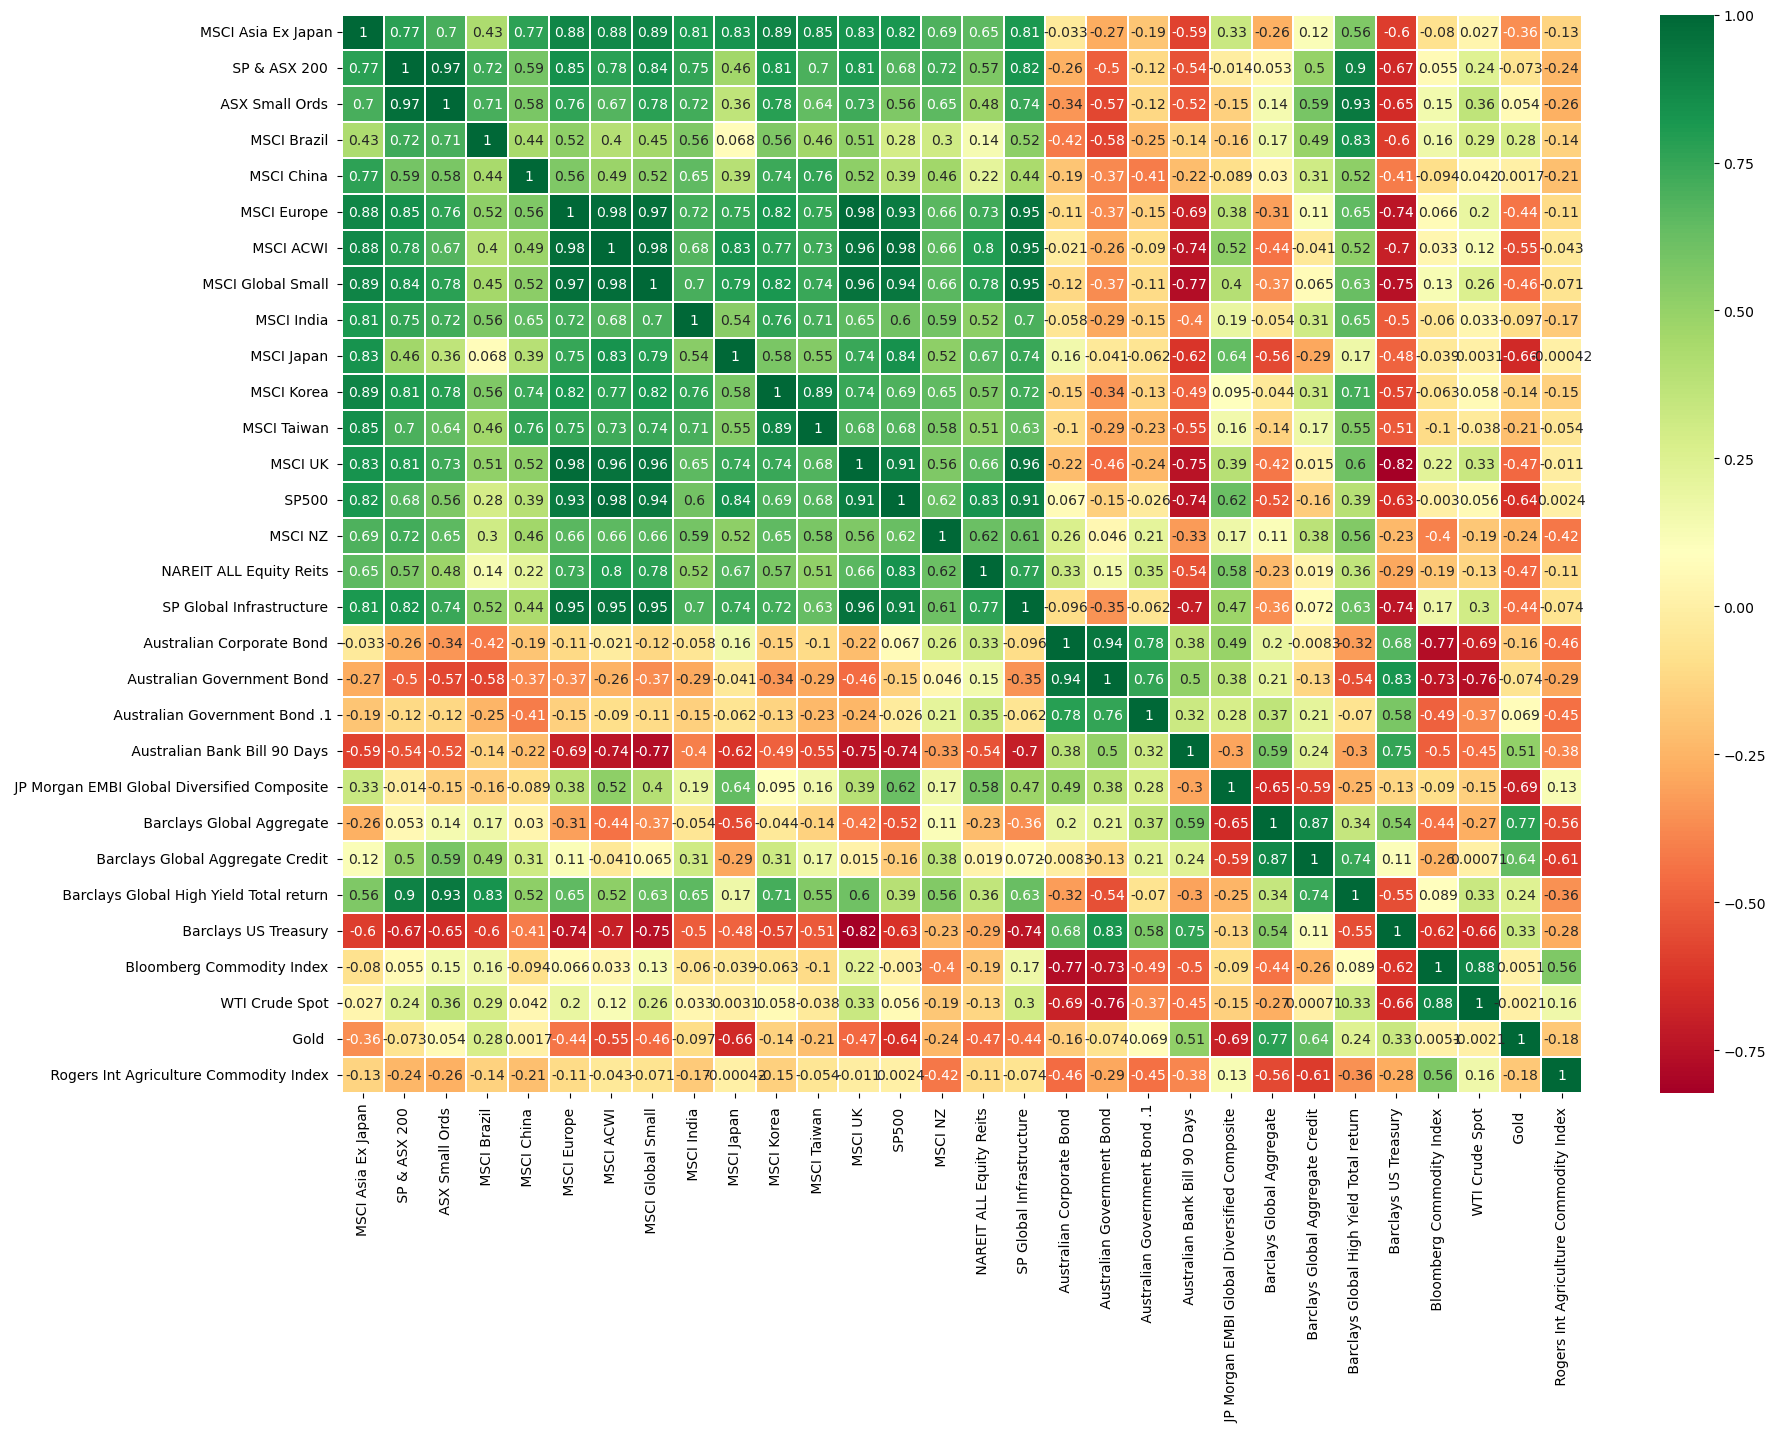

In [20]:
fig, ax = plt.subplots(figsize=(20,14))
sns.heatmap(corr_matrix, annot=True, linewidths=.1, cmap="RdYlGn")